In [1]:
import torch
import torch.nn as nn

In [2]:
class BASIC_D(nn.Module):
    def __init__(self, nc_in, nc_out, ndf, max_layers=3, ngpu=1):
        super(BASIC_D, self).__init__()
        self.ngpu = ngpu
        self.nc_in = nc_in
        self.nc_out = nc_out        
        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc_in+nc_out, ndf),
                        nn.Conv2d(nc_in+nc_out, ndf, 4, 2, 1))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        out_feat = ndf
        for layer in range(1, max_layers):
            in_feat = out_feat
            out_feat = ndf * min(2**layer, 8)
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))            
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
        in_feat = out_feat
        out_feat = ndf*min(2**max_layers, 8)
        main.add_module('last.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 1, 1, bias=False))
        main.add_module('last.{0}.batchnorm'.format(out_feat), nn.BatchNorm2d(out_feat))
        main.add_module('last.{0}.relu'.format(out_feat), nn.LeakyReLU(0.2, inplace=True))
        
        in_feat, out_feat = out_feat, 1        
        main.add_module('final.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 1, 1, bias=True))
        main.add_module('final.{0}.sigmoid'.format(out_feat),  nn.Sigmoid())        
        self.main = main

    def forward(self, a, b):
        x = torch.cat((a, b), 1)        
        output = self.main(x)                    
        return output
    

In [3]:
class UNET_G(nn.Module):
    def __init__(self, isize, nc_in=3, nc_out=3, ngf=64):
        super(UNET_G, self).__init__()       
        assert isize % 16 == 0, "isize has to be a multiple of 16"
        conv_layers = []
        convt_layers = []
        # Down sampling
        tsize = isize
        out_feat = nc_in
        layers = []
        while True:
            assert tsize>=2 and tsize%2==0
            print("tsize", tsize)
            out_feat, in_feat = ngf * min(2**len(conv_layers), 8), out_feat
            use_batchnorm = len(conv_layers)>1 and tsize>2
            layers.append(nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=not use_batchnorm))
            if tsize==2:
                break 
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_feat))
            conv_layers.append(nn.Sequential(*layers))
            layers = [nn.LeakyReLU(0.2, inplace=True)]            
            tsize = tsize // 2
        
        # Up sampling
        use_batchnorm = True
        ll = len(conv_layers) -1
        while tsize<isize:
            layers.append(nn.ReLU())
            out_feat, in_feat = ngf * min(2**ll, 8), out_feat
            layers.append(nn.ConvTranspose2d(in_feat, out_feat,
                                        kernel_size=4, stride=2,padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_feat))
            ll-=1;
            if tsize <=8:
                layers.append(nn.Dropout(0.5))
            convt_layers.append(nn.Sequential(*layers))
            layers = []
            out_feat = out_feat*2
            tsize*=2
        self.output = nn.Sequential(nn.ReLU(), 
                      nn.ConvTranspose2d(out_feat, 1, kernel_size=4, stride=2,padding=1, bias=True),
                      nn.Tanh()
                      )
        self.conv_layers = nn.ModuleList(conv_layers)
        self.convt_layers = nn.ModuleList(convt_layers)
 

    def forward(self, x):
        outputs = []
        for l in self.conv_layers:
            print(l)
            x = l(x)
            outputs.append(x)
            
        for l in self.convt_layers:
            print(l)
            print(len(outputs))
            x = l(x)            
            x = torch.cat((x, outputs.pop()), 1)
        return x

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
λ = 10

loadSize = 286
imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [6]:
netD = BASIC_D(nc_in, nc_out, ndf)
netD.apply(weights_init)

BASIC_D (
  (main): Sequential (
    (initial.conv.6-64): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (initial.relu.64): LeakyReLU (0.2, inplace)
    (pyramid.64-128.conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): LeakyReLU (0.2, inplace)
    (pyramid.128-256.conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): LeakyReLU (0.2, inplace)
    (last.256-512.conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (last.512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (last.512.relu): LeakyReLU (0.2, inplace)
    (final.512-1.conv): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (final.1.sigmoid): Sigm

In [7]:
netG = UNET_G(imageSize, nc_in, nc_out, ngf)
netG.apply(weights_init)

tsize 256
tsize 128
tsize 64
tsize 32
tsize 16
tsize 8
tsize 4
tsize 2


UNET_G (
  (output): Sequential (
    (0): ReLU ()
    (1): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Tanh ()
  )
  (conv_layers): ModuleList (
    (0): Sequential (
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Sequential (
      (0): LeakyReLU (0.2, inplace)
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (2): Sequential (
      (0): LeakyReLU (0.2, inplace)
      (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    )
    (3): Sequential (
      (0): LeakyReLU (0.2, inplace)
      (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
    (4): Sequential (
      (0): LeakyReLU (0.2, inplace)
      (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), paddi

In [8]:
inputA = torch.FloatTensor(batchSize, nc_in, imageSize, imageSize)
inputB = torch.FloatTensor(batchSize, nc_out, imageSize, imageSize)
one = torch.FloatTensor([1])
zero = torch.FloatTensor([1])

In [9]:
#netD.cuda()
#netG.cuda()
#inputA = inputA.cuda()
#inputB = inputB.cuda()
#one, zero = one.cuda(), zero.cuda()


In [10]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

data = "edges2shoes"
data = "facades"
direction = 0
trainAB = load_data('pix2pix/{}/train/*.jpg'.format(data))
valAB = load_data('pix2pix/{}/val/*.jpg'.format(data))
assert len(trainAB) and len(valAB)

In [11]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [12]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

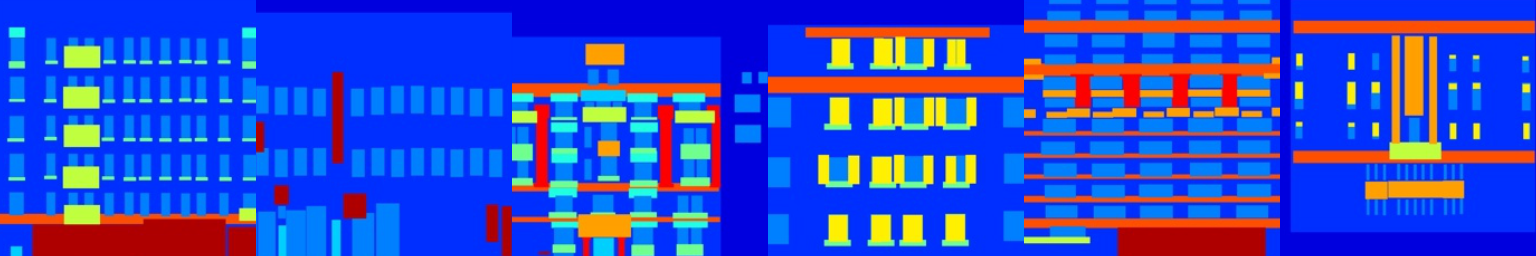

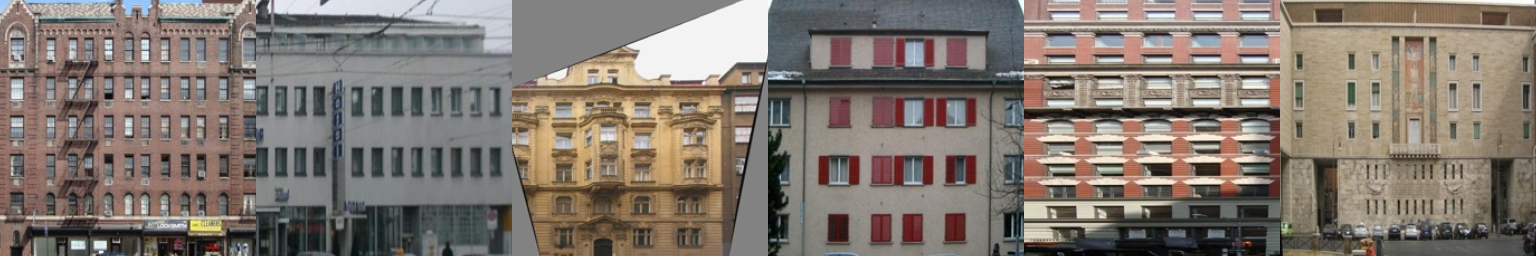

In [13]:
channel_first=True
channel_axis=1
train_batch = minibatch(trainAB, 6, direction=direction)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)
#del train_batch, trainA, trainB

In [14]:
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [15]:
optimizerD = optim.Adam(netD.parameters(), lr = lrD, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lrG, betas=(0.5, 0.999))

In [16]:
netG.zero_grad()
_, trainA, trainB = next(train_batch)

trainA = torch.from_numpy(trainA) #.cuda()
trainB = torch.from_numpy(trainB) #.cuda()
inputA.resize_as_(trainA).copy_(trainA)
inputB.resize_as_(trainB).copy_(trainB)

inputvA = Variable(inputA)
inputvB = Variable(inputB)
netG(inputvA)

Sequential (
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
Sequential (
  (0): LeakyReLU (0.2, inplace)
  (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
Sequential (
  (0): LeakyReLU (0.2, inplace)
  (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
)
Sequential (
  (0): LeakyReLU (0.2, inplace)
  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
)
Sequential (
  (0): LeakyReLU (0.2, inplace)
  (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
)
Sequential (
  (0): LeakyReLU (0.2, inplace)
  (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
)
Sequenti

Variable containing:
( 0 , 0 ,.,.) = 
  2.6948e-03  9.5458e-02 -7.2384e-02  ...   2.7486e-01  6.2956e-03  1.7104e-01
  2.6055e-01 -3.9540e-01 -2.8909e-01  ...   3.3185e-01  2.5034e-01  4.4219e-01
 -5.1386e-02 -5.9691e-01 -8.4881e-01  ...  -3.4820e-01 -5.9762e-02 -1.3143e-01
                 ...                   ⋱                   ...                
 -4.0611e-02 -6.1703e-02  1.1576e+00  ...   2.2602e-01  1.0135e-01  3.4810e-01
  4.1729e-01 -1.4824e+00  1.7608e-01  ...  -5.6355e-01  1.1268e-01 -2.2080e-01
 -3.4132e-01  5.9436e-02 -2.8742e-01  ...   2.1359e-01 -7.4076e-01 -8.1975e-03

( 0 , 1 ,.,.) = 
 -2.6618e-01 -9.3878e-01  3.0793e-01  ...  -4.6080e-01 -3.0268e-01 -4.2853e-01
 -2.2530e-01 -4.1164e-01  1.2099e-01  ...  -5.9646e-01  5.8295e-01  1.3713e-01
  1.2213e-01 -8.5669e-01 -7.4078e-01  ...  -6.3232e-02  9.2883e-02 -2.7021e-01
                 ...                   ⋱                   ...                
 -1.6877e-01 -6.8326e-01  2.8436e-01  ...   2.3406e-01 -2.0349e-01 -5.4869e

In [19]:
netD.zero_grad()
loss = nn.BCELoss()
_, trainA, trainB = next(train_batch)

trainA = torch.from_numpy(trainA) #.cuda()
trainB = torch.from_numpy(trainB) #.cuda()
inputA.resize_as_(trainA).copy_(trainA)
inputB.resize_as_(trainB).copy_(trainB)

inputvA = Variable(inputA)
inputvB = Variable(inputB)

output_D_real = netD(inputvA, inputvB)
errD_real = loss(output_D_real, one) )
errD_real.backward()

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([6, 1, 30, 30])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


ValueError: Target and input must have the same number of elements. target nelement (1) != input nelement (5400)

In [ ]:
import time
t0 = time.time()
niter = 1000
gen_iterations = 0
for epoch in range(niter):
    i = 0
    batches = train_X.shape[0]//batchSize
    while i < batches:
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        if gen_iterations < 25 or gen_iterations %500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1
            
            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
                
            real_data = torch.from_numpy(
                np.moveaxis(train_X[i*batchSize:(i+1)*batchSize], 3,1)
            ).cuda()
            i+=1
            
            netD.zero_grad()
            input.resize_as_(real_data).copy_(real_data)
            inputv = Variable(input)
            
            errD_real = netD(inputv)
            errD_real.backward(one)
            
            # train with fake
            noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise, volatile = True) # totally freeze netG
            fake = Variable(netG(noisev).data)
            inputv = fake
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            optimizerD.step()

        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        errG = netD(fake)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        if gen_iterations%500 ==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, batches, gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]), time.time()-t0)
        if gen_iterations%500 == 0:            
            fake = netG(Variable(fixed_noise, volatile=True))            
            showX(np.moveaxis(fake.data.cpu().numpy(),1,3), 4)
        

-------------------------